In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input, Activation, Flatten 
from keras.layers import TimeDistributed, Conv2D, Bidirectional
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf
%matplotlib notebook

Using TensorFlow backend.


In [2]:
print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(keras.__version__)

1.13.3
0.20.3
1.4.0-rc0
2.0.8


In [3]:
#f = open('sp500.csv', 'rb').read()
#data = f.decode().split('\n')def updown(a,b):

In [4]:
# load csv as np array
raw = np.loadtxt(open('DJI-ohlc.csv'), delimiter=',')
len(raw)

8260

In [5]:
type(raw), len(raw[0]), raw[0], raw[-1]

(numpy.ndarray,
 4,
 array([ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995]),
 array([ 23442.900391,  23517.710938,  23388.910156,  23435.009766]))

In [6]:
# create list of sequences/window of length seqlen
# set sequence length
seqlen = 20
winraw = []
for i in range(len(raw)-seqlen):
    winraw.append(raw[i:i+seqlen,:])

In [7]:
# convert winraw to np.array
winarr = np.array(winraw)

In [8]:
winarr[0],len(winarr), len(winarr[0]),type(winarr)

(array([[ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995],
        [ 1297.369995,  1305.099976,  1278.930054,  1287.880005],
        [ 1283.23999 ,  1293.400024,  1272.640015,  1286.77002 ],
        [ 1276.939941,  1286.109985,  1269.77002 ,  1277.719971],
        [ 1272.079956,  1294.939941,  1268.98999 ,  1290.079956],
        [ 1294.060059,  1301.130005,  1278.599976,  1285.22998 ],
        [ 1284.890015,  1294.5     ,  1275.069946,  1280.589966],
        [ 1285.      ,  1297.040039,  1279.810059,  1290.079956],
        [ 1290.079956,  1297.150024,  1281.359985,  1289.969971],
        [ 1287.98999 ,  1291.73999 ,  1268.660034,  1276.060059],
        [ 1271.199951,  1283.130005,  1266.339966,  1276.609985],
        [ 1277.829956,  1304.660034,  1274.51001 ,  1297.920044],
        [ 1301.790039,  1307.530029,  1283.680054,  1287.880005],
        [ 1289.199951,  1296.27002 ,  1275.069946,  1282.02002 ],
        [ 1279.810059,  1287.430054,  1273.52002 ,  1280.589966],
        [ 

In [9]:
winraw[-1][-1] == raw[-2]

array([ True,  True,  True,  True], dtype=bool)

In [10]:
#halfseqlen = round(seqlen/2)
#halfseqlen

In [11]:
zz = 0
winarr[zz], winarr[zz][-1][-1],winarr[zz][0][-1]

(array([[ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995],
        [ 1297.369995,  1305.099976,  1278.930054,  1287.880005],
        [ 1283.23999 ,  1293.400024,  1272.640015,  1286.77002 ],
        [ 1276.939941,  1286.109985,  1269.77002 ,  1277.719971],
        [ 1272.079956,  1294.939941,  1268.98999 ,  1290.079956],
        [ 1294.060059,  1301.130005,  1278.599976,  1285.22998 ],
        [ 1284.890015,  1294.5     ,  1275.069946,  1280.589966],
        [ 1285.      ,  1297.040039,  1279.810059,  1290.079956],
        [ 1290.079956,  1297.150024,  1281.359985,  1289.969971],
        [ 1287.98999 ,  1291.73999 ,  1268.660034,  1276.060059],
        [ 1271.199951,  1283.130005,  1266.339966,  1276.609985],
        [ 1277.829956,  1304.660034,  1274.51001 ,  1297.920044],
        [ 1301.790039,  1307.530029,  1283.680054,  1287.880005],
        [ 1289.199951,  1296.27002 ,  1275.069946,  1282.02002 ],
        [ 1279.810059,  1287.430054,  1273.52002 ,  1280.589966],
        [ 

In [12]:
trends = ['up', 'dn', 'flat']

In [13]:
# helper functions to check if uptrend, downtrend or flat
# 1st part is to get change(difference) of each window from 1st to last close
# 2nd part is to check the stats of the difference
# 3rd part is to check trend

# get range of each window by subtracting last close from 1st close
# and dividing by 1st close to get a % change
def getRange(w):
    wa = w[0][-1]
    #wb = w[halfseqlen][-1]
    wc = w[-1][-1]
    return (wc-wa)/wa

# check trend and give Y
def checkTrend(a,b):
    # uptrend is 1, downtrend is 2, flat is 3
    if a >= b:
        return 0
    elif a <= -b:
        return 1
    else:
        return 2


In [14]:
windowrange = []
for w in winarr:
    windowrange.append(getRange(w))


In [15]:
len(windowrange)

8240

In [16]:
absrange = [abs(x) for x in windowrange]

In [17]:
len(absrange),absrange[:10]

(8240,
 [0.0050362906540061415,
  0.0053187998675388783,
  0.0021449131990190179,
  0.016936429335970726,
  0.00042627357896879464,
  0.0051508260023625501,
  0.00017177317161642263,
  0.014378897147984232,
  0.015744503714497701,
  0.0058853107634175752])

In [18]:
max(absrange),min(absrange), np.mean(absrange)

(0.32293376031473131, 0.0, 0.031925640746101998)

In [19]:
max(windowrange),np.argmax(windowrange)

(0.22461109702830503, 6079)

In [20]:
winarr[6079]

array([[ 6625.740234,  6709.609863,  6516.859863,  6547.049805],
       [ 6547.009766,  6926.490234,  6546.609863,  6926.490234],
       [ 6923.129883,  7015.060059,  6867.549805,  6930.399902],
       [ 6932.390137,  7184.709961,  6872.25    ,  7170.060059],
       [ 7167.350098,  7242.620117,  7105.859863,  7223.97998 ],
       [ 7225.330078,  7392.910156,  7206.850098,  7216.970215],
       [ 7218.      ,  7396.810059,  7172.049805,  7395.700195],
       [ 7395.700195,  7571.640137,  7257.27002 ,  7486.580078],
       [ 7489.680176,  7548.459961,  7369.259766,  7400.799805],
       [ 7402.310059,  7460.930176,  7257.830078,  7278.379883],
       [ 7279.25    ,  7780.720215,  7278.779785,  7775.859863],
       [ 7773.470215,  7796.569824,  7646.990234,  7659.970215],
       [ 7659.810059,  7863.629883,  7550.060059,  7749.810059],
       [ 7752.359863,  7931.330078,  7752.279785,  7924.560059],
       [ 7922.569824,  7922.569824,  7735.950195,  7776.180176],
       [ 7773.310059,  77

In [21]:
avgchg = np.mean(absrange)
avgchg

0.031925640746101998

In [22]:
y = []
for w in windowrange:
    y.append(checkTrend(w,avgchg-0.01))

In [23]:
y.count(0),y.count(1), y.count(2)

(2962, 1591, 3687)

In [24]:
# check y against winarr values
z = 0

print(winarr[z])
print(y[z])
print(winarr[z][-1][-1]-winarr[z][0][-1],(winarr[z][-1][-1]-winarr[z][0][-1])/winarr[z][0][-1])

[[ 1277.719971  1295.48999   1266.890015  1292.619995]
 [ 1297.369995  1305.099976  1278.930054  1287.880005]
 [ 1283.23999   1293.400024  1272.640015  1286.77002 ]
 [ 1276.939941  1286.109985  1269.77002   1277.719971]
 [ 1272.079956  1294.939941  1268.98999   1290.079956]
 [ 1294.060059  1301.130005  1278.599976  1285.22998 ]
 [ 1284.890015  1294.5       1275.069946  1280.589966]
 [ 1285.        1297.040039  1279.810059  1290.079956]
 [ 1290.079956  1297.150024  1281.359985  1289.969971]
 [ 1287.98999   1291.73999   1268.660034  1276.060059]
 [ 1271.199951  1283.130005  1266.339966  1276.609985]
 [ 1277.829956  1304.660034  1274.51001   1297.920044]
 [ 1301.790039  1307.530029  1283.680054  1287.880005]
 [ 1289.199951  1296.27002   1275.069946  1282.02002 ]
 [ 1279.810059  1287.430054  1273.52002   1280.589966]
 [ 1280.150024  1292.51001   1272.530029  1283.130005]
 [ 1280.369995  1287.099976  1272.640015  1279.040039]
 [ 1277.939941  1286.550049  1269.98999   1275.839966]
 [ 1269.98

In [25]:
len(winarr)==len(y)

True

In [26]:
winarr[0], len(winarr[0])

(array([[ 1277.719971,  1295.48999 ,  1266.890015,  1292.619995],
        [ 1297.369995,  1305.099976,  1278.930054,  1287.880005],
        [ 1283.23999 ,  1293.400024,  1272.640015,  1286.77002 ],
        [ 1276.939941,  1286.109985,  1269.77002 ,  1277.719971],
        [ 1272.079956,  1294.939941,  1268.98999 ,  1290.079956],
        [ 1294.060059,  1301.130005,  1278.599976,  1285.22998 ],
        [ 1284.890015,  1294.5     ,  1275.069946,  1280.589966],
        [ 1285.      ,  1297.040039,  1279.810059,  1290.079956],
        [ 1290.079956,  1297.150024,  1281.359985,  1289.969971],
        [ 1287.98999 ,  1291.73999 ,  1268.660034,  1276.060059],
        [ 1271.199951,  1283.130005,  1266.339966,  1276.609985],
        [ 1277.829956,  1304.660034,  1274.51001 ,  1297.920044],
        [ 1301.790039,  1307.530029,  1283.680054,  1287.880005],
        [ 1289.199951,  1296.27002 ,  1275.069946,  1282.02002 ],
        [ 1279.810059,  1287.430054,  1273.52002 ,  1280.589966],
        [ 

In [27]:
winarr.shape,type(winarr),type(winarr[0]),type(winarr[0][0]),type(winarr[0][0][0])

((8240, 20, 4), numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.float64)

In [28]:
winarrhalf = []
seqlenhalf = round(seqlen/2)
for w in winarr:
    whalf = w[:seqlenhalf]
    winarrhalf.append(whalf)

In [29]:
len(winarrhalf), len(winarrhalf[0])

(8240, 10)

In [30]:
# normalize X
for w in winarrhalf:
    #print(w[0][0])
    w/=w[0][0]
    w -= 1

In [31]:
winarrhalf[1]

array([[ 0.        ,  0.00595819, -0.01421332, -0.00731479],
       [-0.01089127, -0.00306001, -0.01906162, -0.00817036],
       [-0.01574728, -0.0086791 , -0.02127379, -0.01514604],
       [-0.01949331, -0.00187306, -0.02187503, -0.00561909],
       [-0.00255127,  0.00289818, -0.01446775, -0.0093574 ],
       [-0.00961945, -0.00221216, -0.01718866, -0.01293388],
       [-0.00953467, -0.00025433, -0.01353503, -0.00561909],
       [-0.00561909, -0.00016955, -0.01234036, -0.00570387],
       [-0.00723002, -0.00433955, -0.02212935, -0.01642549],
       [-0.02017161, -0.01097604, -0.02391764, -0.01600161]])

In [32]:
winarrhalf = np.array(winarrhalf)
winarrhalf.shape

(8240, 10, 4)

In [33]:
# convert yr and winnorm to np.array
yarr = np.array(y)
#winnormarr = np.array(winnorm)

In [34]:
yarr.shape, winarr.shape

((8240,), (8240, 20, 4))

In [35]:
# reshape yarr
yarr = np.reshape(yarr,(yarr.shape[0],1))
yarr.shape, winarr.shape

((8240, 1), (8240, 20, 4))

In [36]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
#x_data,y_data = unison_shuffled_copies(x_data,y_data)

In [37]:
row = round(0.8 * winarrhalf.shape[0])

In [38]:
#train = winnormarr[:int(row), :]

In [39]:
#np.random.shuffle(train)

In [40]:
x_train = winarrhalf[:row]
y_train = yarr[:row]

In [41]:
x_test = winarrhalf[int(row):]
y_test = yarr[int(row):]

In [42]:
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((6592, 10, 4), (6592, 1), (1648, 10, 4), (1648, 1))

In [43]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2])) 

In [44]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6592, 10, 4), (6592, 1), (1648, 10, 4), (1648, 1))

In [45]:
# convert class vectors to binary class matrices
num_classes = len(trends)
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

In [46]:
inputshape = ( x_train.shape[1], x_train.shape[2]) #,x_train.shape[3])
print(inputshape)

(10, 4)


In [47]:
# define the input shape
inp = Input(shape=inputshape)

In [48]:

#print('our input shape is ',(x_train.shape[1], x_train.shape[2]) )
#x = TimeDistributed(Conv2D(32,(2,2), activation='relu'))(inp)
#x = TimeDistributed(Flatten())(x)

x = LSTM(32, return_sequences = True)(inp) 
#x = Dropout(0.2)(x)
x = LSTM(64, return_sequences = False, go_backwards=True)(x)
#x = Dropout(0.2)(x)

#x = TimeDistributed(Conv2D(32,(2,2), activation='relu')0)(x)
x = Dropout(0.2)(x)
#x = Flatten()(x)
output = Dense(num_classes, activation ='softmax')(x)

model = Model(inputs = inp, outputs=output )

In [49]:
#optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 4)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            4736      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 29,763
Trainable params: 29,763
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(x_train, y_train,
                    batch_size = 64, 
                    epochs=200, 
                    verbose=1, 
                    validation_data=(x_test, y_test))

Train on 6592 samples, validate on 1648 samples
Epoch 1/200
6592/6592 [==============================] - 3s - loss: 1.0268 - acc: 0.4589 - val_loss: 0.9158 - val_acc: 0.5674
Epoch 2/200
6592/6592 [==============================] - 2s - loss: 0.9210 - acc: 0.5535 - val_loss: 0.8367 - val_acc: 0.6135
Epoch 3/200
6592/6592 [==============================] - 2s - loss: 0.8811 - acc: 0.5765 - val_loss: 0.8588 - val_acc: 0.6110
Epoch 4/200
6592/6592 [==============================] - 2s - loss: 0.8805 - acc: 0.5846 - val_loss: 0.8486 - val_acc: 0.6147
Epoch 5/200
6592/6592 [==============================] - 2s - loss: 0.8775 - acc: 0.5850 - val_loss: 0.8467 - val_acc: 0.6135
Epoch 6/200
6592/6592 [==============================] - 2s - loss: 0.8717 - acc: 0.5871 - val_loss: 0.8398 - val_acc: 0.6250
Epoch 7/200
6592/6592 [==============================] - 2s - loss: 0.8795 - acc: 0.5837 - val_loss: 0.8408 - val_acc: 0.6177
Epoch 8/200
6592/6592 [==============================] - 2s - loss: 0.

6592/6592 [==============================] - 2s - loss: 0.8232 - acc: 0.6150 - val_loss: 0.7818 - val_acc: 0.6274
Epoch 66/200
6592/6592 [==============================] - 2s - loss: 0.8212 - acc: 0.6223 - val_loss: 0.7929 - val_acc: 0.6299
Epoch 67/200
6592/6592 [==============================] - 2s - loss: 0.8219 - acc: 0.6120 - val_loss: 0.7882 - val_acc: 0.6189
Epoch 68/200
6592/6592 [==============================] - 2s - loss: 0.8225 - acc: 0.6153 - val_loss: 0.7795 - val_acc: 0.6280
Epoch 69/200
6592/6592 [==============================] - 2s - loss: 0.8178 - acc: 0.6186 - val_loss: 0.8058 - val_acc: 0.6341
Epoch 70/200
6592/6592 [==============================] - 2s - loss: 0.8213 - acc: 0.6147 - val_loss: 0.7861 - val_acc: 0.6323
Epoch 71/200
6592/6592 [==============================] - 2s - loss: 0.8199 - acc: 0.6198 - val_loss: 0.7748 - val_acc: 0.6359
Epoch 72/200
6592/6592 [==============================] - 2s - loss: 0.8217 - acc: 0.6162 - val_loss: 0.7979 - val_acc: 0.63

6592/6592 [==============================] - 2s - loss: 0.8102 - acc: 0.6235 - val_loss: 0.7787 - val_acc: 0.6317
Epoch 130/200
6592/6592 [==============================] - 2s - loss: 0.8105 - acc: 0.6282 - val_loss: 0.7756 - val_acc: 0.6335
Epoch 131/200
6592/6592 [==============================] - 2s - loss: 0.8094 - acc: 0.6220 - val_loss: 0.7830 - val_acc: 0.6201
Epoch 132/200
6592/6592 [==============================] - 2s - loss: 0.8093 - acc: 0.6256 - val_loss: 0.7845 - val_acc: 0.6438
Epoch 133/200
6592/6592 [==============================] - 2s - loss: 0.8099 - acc: 0.6211 - val_loss: 0.7764 - val_acc: 0.6311
Epoch 134/200
6592/6592 [==============================] - 2s - loss: 0.8085 - acc: 0.6238 - val_loss: 0.7808 - val_acc: 0.6323
Epoch 135/200
6592/6592 [==============================] - 2s - loss: 0.8121 - acc: 0.6229 - val_loss: 0.7816 - val_acc: 0.6292
Epoch 136/200
6592/6592 [==============================] - 2s - loss: 0.8108 - acc: 0.6252 - val_loss: 0.7780 - val_ac

6592/6592 [==============================] - 2s - loss: 0.7925 - acc: 0.6308 - val_loss: 0.7911 - val_acc: 0.6341
Epoch 194/200
6592/6592 [==============================] - 2s - loss: 0.7912 - acc: 0.6314 - val_loss: 0.8027 - val_acc: 0.6280
Epoch 195/200
6592/6592 [==============================] - 2s - loss: 0.7936 - acc: 0.6341 - val_loss: 0.7878 - val_acc: 0.6311
Epoch 196/200
6592/6592 [==============================] - 2s - loss: 0.7921 - acc: 0.6343 - val_loss: 0.7956 - val_acc: 0.6414
Epoch 197/200
6592/6592 [==============================] - 2s - loss: 0.7885 - acc: 0.6329 - val_loss: 0.8071 - val_acc: 0.6323
Epoch 198/200
6592/6592 [==============================] - 2s - loss: 0.7937 - acc: 0.6305 - val_loss: 0.7882 - val_acc: 0.6274
Epoch 199/200
6592/6592 [==============================] - 2s - loss: 0.7910 - acc: 0.6387 - val_loss: 0.7916 - val_acc: 0.6341
Epoch 200/200
6592/6592 [==============================] - 2s - loss: 0.7897 - acc: 0.6346 - val_loss: 0.7955 - val_ac

In [52]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

<IPython.core.display.Javascript object>


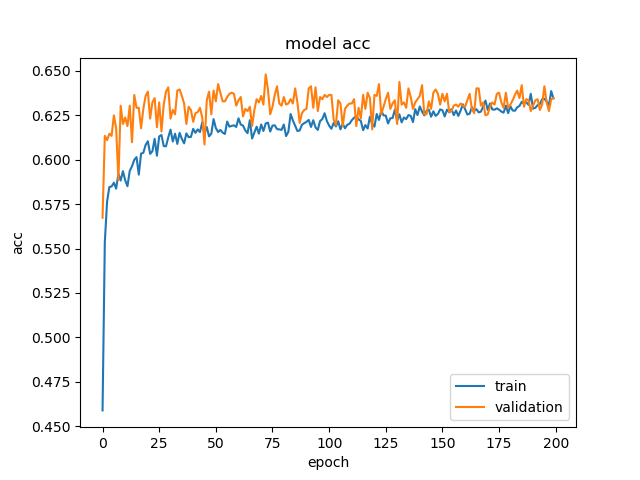

In [53]:
plot_train(history)

In [54]:
evaluation = model.evaluate(x_test, y_test, batch_size=512)
print('Model Accuracy = {:.2f} %'.format(evaluation[1]*100))
print('Model Loss = {:05.2f}'.format(evaluation[0]))

 512/1648 [========>.....................] - ETA: 0sModel Accuracy = 63.47 %
Model Loss = 00.80
